In [1]:
# --- Clean imports & config ---
from pathlib import Path
import zipfile, urllib.request, random, time

import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import random
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode


SEED = 42
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_DIR = Path("./data/jsrt").resolve()
BASE_DIR.mkdir(parents=True, exist_ok=True)

def download_if_needed(name: str, url: str, dst_dir: Path = BASE_DIR) -> Path:
    """Downloads <name>.zip to dst_dir and extracts into dst_dir/<name>."""
    out_dir = dst_dir / name
    zip_path = dst_dir / f"{name}.zip"
    if out_dir.exists() and any(out_dir.iterdir()):
        print(f"[{name}] ready at {out_dir}")
        return out_dir
    if not zip_path.exists():
        print(f"[DL] {name} -> {zip_path}")
        urllib.request.urlretrieve(url, zip_path)
    print(f"[EXTRACT] {zip_path} -> {out_dir}")
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(out_dir)
    return out_dir

# ImageNet-normalized transforms (classification)
weights = ResNet18_Weights.DEFAULT

def get_imagenet_preprocess(weights):
    try:
        return weights.transforms()  # callable; works in newer torchvision
    except Exception:
        # Fallback for older torchvision
        from torchvision.transforms import InterpolationMode
        return transforms.Compose([
            transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

preprocess = get_imagenet_preprocess(weights)

cls_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    preprocess,  
])

# --- Generic training helpers (classification) ---
def build_resnet18(num_classes: int, freeze_backbone: bool = True) -> nn.Module:
    m = resnet18(weights=weights)
    if freeze_backbone:
        for p in m.parameters():
            p.requires_grad = False
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(DEVICE)

def run_epoch(model, loader, criterion, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)
    losses, preds_all, targs_all = 0.0, [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        if train_mode: optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        if train_mode:
            loss.backward(); optimizer.step()
        losses += loss.item() * x.size(0)
        preds_all.extend(out.argmax(1).detach().cpu().tolist())
        targs_all.extend(y.detach().cpu().tolist())
    return losses / len(loader.dataset), accuracy_score(targs_all, preds_all)

def fit(model, train_loader, val_loader, epochs=5, lr=1e-3):
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    best_acc, best = -1.0, None
    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = run_epoch(model, train_loader, crit, optimizer=opt)
        va_loss, va_acc = run_epoch(model, val_loader,   crit, optimizer=None)
        if va_acc > best_acc:
            best_acc, best = va_acc, {k: v.cpu() for k, v in model.state_dict().items()}
        print(f"E{ep:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f} | {time.time()-t0:.1f}s")
    if best is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best.items()})
    return model


In [2]:
#0 Read and Write

PRACTICE = {
    "Practice_PNGandJPG": "http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2019/07/Practice_PNGandJPG.zip",
    "Practice_DICOM":     "http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2019/07/Practice_DICOM.zip",
}
prac_img_dir = download_if_needed("Practice_PNGandJPG", PRACTICE["Practice_PNGandJPG"])
prac_dcm_dir = download_if_needed("Practice_DICOM",     PRACTICE["Practice_DICOM"])

def ensure_uint8(arr):
    arr = np.asarray(arr).astype(np.float32)
    lo, hi = np.percentile(arr, [0.5, 99.5])
    if hi <= lo:
        lo, hi = arr.min(), arr.max()
    arr = np.clip(arr, lo, hi)
    arr = (255.0 * (arr - lo) / max(hi - lo, 1e-6)).round().astype(np.uint8)
    return arr

def png_to_jpg(png_path, out_dir):
    im = Image.open(png_path).convert("L")
    out_dir.mkdir(parents=True, exist_ok=True)
    Image.fromarray(ensure_uint8(np.array(im)), mode="L").save(out_dir / (png_path.stem + ".jpg"), quality=95)

def jpg_to_png(jpg_path, out_dir):
    im = Image.open(jpg_path).convert("L")
    out_dir.mkdir(parents=True, exist_ok=True)
    Image.fromarray(ensure_uint8(np.array(im)), mode="L").save(out_dir / (jpg_path.stem + ".png"))

def dcm_to_png(dcm_path, out_dir):
    try:
        import pydicom
    except ImportError as e:
        raise ImportError("Please install pydicom first: pip install pydicom") from e
    ds = pydicom.dcmread(str(dcm_path))
    arr = ensure_uint8(ds.pixel_array)
    out_dir.mkdir(parents=True, exist_ok=True)
    Image.fromarray(arr, mode="L").save(out_dir / (dcm_path.stem + ".png"))

# 3) Enumerate & convert a few examples (non-destructive; saves to _converted/_png)
pngs = sorted(prac_img_dir.rglob("*.png"))
jpgs = sorted(prac_img_dir.rglob("*.jpg"))
dcms = sorted(prac_dcm_dir.rglob("*.dcm"))

out_img_conv = prac_img_dir / "_converted"   # stays inside Practice_PNGandJPG
out_dcm_png  = prac_dcm_dir / "_png"         # stays inside Practice_DICOM

MAX_SAVE = 5  # keep quick; change as needed
for p in pngs[:MAX_SAVE]:
    png_to_jpg(p, out_img_conv)
for j in jpgs[:MAX_SAVE]:
    jpg_to_png(j, out_img_conv)
for d in dcms[:MAX_SAVE]:
    dcm_to_png(d, out_dcm_png)

print(f"[Task 0] PNG={len(pngs)} JPG={len(jpgs)} DICOM={len(dcms)}")
if pngs: print("  Example PNG->JPG:", out_img_conv / (pngs[0].stem + ".jpg"))
if jpgs: print("  Example JPG->PNG:", out_img_conv / (jpgs[0].stem + ".png"))
if dcms: print("  Example DCM->PNG:", out_dcm_png  / (dcms[0].stem + ".png"))

[Practice_PNGandJPG] ready at /scratch/hdharmen/ASU/CSE 507/data/jsrt/Practice_PNGandJPG
[Practice_DICOM] ready at /scratch/hdharmen/ASU/CSE 507/data/jsrt/Practice_DICOM


/tmp/ipykernel_3226101/3084858846.py:22: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(ensure_uint8(np.array(im)), mode="L").save(out_dir / (png_path.stem + ".jpg"), quality=95)
/tmp/ipykernel_3226101/3084858846.py:27: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(ensure_uint8(np.array(im)), mode="L").save(out_dir / (jpg_path.stem + ".png"))
/tmp/ipykernel_3226101/3084858846.py:37: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(arr, mode="L").save(out_dir / (dcm_path.stem + ".png"))


[Task 0] PNG=15 JPG=15 DICOM=10
  Example PNG->JPG: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Practice_PNGandJPG/_converted/JPCLN001.jpg
  Example JPG->PNG: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Practice_PNGandJPG/_converted/JPCLN001.png
  Example DCM->PNG: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Practice_DICOM/_png/JPCLN001.png


In [3]:
# Directions01
DATASETS = {
    "Directions01": "http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/11/Directions01.zip",
}

directions_dir = download_if_needed("Directions01", DATASETS["Directions01"])
train_dir_1 = directions_dir / "train"   # expects subfolders: Up, Down, Left, Right
test_dir_1  = directions_dir / "test"

train_ds_1 = datasets.ImageFolder(train_dir_1, transform=cls_tfms)
test_ds_1  = datasets.ImageFolder(test_dir_1,  transform=cls_tfms)
print("Classes (Task 1):", train_ds_1.classes)

num_workers = 2
train_ld_1 = DataLoader(train_ds_1, batch_size=32, shuffle=True,  num_workers=num_workers, pin_memory=True)
test_ld_1  = DataLoader(test_ds_1,  batch_size=64, shuffle=False, num_workers=num_workers, pin_memory=True)

model_1 = build_resnet18(num_classes=4, freeze_backbone=True)
model_1 = fit(model_1, train_ld_1, test_ld_1, epochs=5, lr=1e-3)

test_loss_1, test_acc_1 = run_epoch(model_1, test_ld_1, nn.CrossEntropyLoss(), optimizer=None)
print(f"[Task 1] Test loss: {test_loss_1:.4f} | Test acc: {test_acc_1:.3f}")


[Directions01] ready at /scratch/hdharmen/ASU/CSE 507/data/jsrt/Directions01
Classes (Task 1): ['down', 'left', 'right', 'up']
E01 | train 0.8438/0.747 | val 0.7818/0.750 | 17.6s
E02 | train 0.3540/0.947 | val 0.3092/0.975 | 1.7s
E03 | train 0.2174/0.985 | val 0.1689/0.975 | 1.7s
E04 | train 0.1689/0.979 | val 0.1226/1.000 | 1.8s
E05 | train 0.1273/0.993 | val 0.1135/0.975 | 1.7s
[Task 1] Test loss: 0.1226 | Test acc: 1.000


In [9]:
# Gender01
DATASETS["Gender01"] = "http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/11/Gender01.zip"

gender_dir = download_if_needed("Gender01", DATASETS["Gender01"])
train_dir_2 = gender_dir / "train"   # subfolders: female, male
test_dir_2  = gender_dir / "test"

train_ds_2 = datasets.ImageFolder(train_dir_2, transform=cls_tfms)
test_ds_2  = datasets.ImageFolder(test_dir_2,  transform=cls_tfms)
print("Classes (Task 2):", train_ds_2.classes)

train_ld_2 = DataLoader(train_ds_2, batch_size=16, shuffle=True,  num_workers=num_workers, pin_memory=True)
test_ld_2  = DataLoader(test_ds_2,  batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=True)

model_2 = build_resnet18(num_classes=2, freeze_backbone=True)
model_2 = fit(model_2, train_ld_2, test_ld_2, epochs=6, lr=1e-3)

test_loss_2, test_acc_2 = run_epoch(model_2, test_ld_2, nn.CrossEntropyLoss(), optimizer=None)
print(f"[Task 2] Test loss: {test_loss_2:.4f} | Test acc: {test_acc_2:.3f}")


def collect_preds(model, loader):
    model.eval(); P=[]; T=[]
    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE)
            P += model(x).argmax(1).cpu().tolist()
            T += y.tolist()
    return np.array(P), np.array(T)

p2, t2 = collect_preds(model_2, test_ld_2)
print("\n[Task 2] report:\n", classification_report(t2, p2, target_names=train_ds_2.classes, digits=3))
print("[Task 2] confusion:\n", confusion_matrix(t2, p2))

[Gender01] ready at /scratch/hdharmen/ASU/CSE 507/data/jsrt/Gender01
Classes (Task 2): ['female', 'male']
E01 | train 0.6466/0.610 | val 0.6250/0.667 | 7.0s
E02 | train 0.5214/0.831 | val 0.7320/0.473 | 0.8s
E03 | train 0.4514/0.805 | val 0.5267/0.806 | 1.8s
E04 | train 0.3908/0.896 | val 0.5959/0.634 | 0.7s
E05 | train 0.3824/0.870 | val 0.4641/0.882 | 2.2s
E06 | train 0.2969/0.955 | val 0.4796/0.806 | 1.5s
[Task 2] Test loss: 0.4641 | Test acc: 0.882

[Task 2] report:
               precision    recall  f1-score   support

      female      0.897     0.833     0.864        42
        male      0.870     0.922     0.895        51

    accuracy                          0.882        93
   macro avg      0.884     0.877     0.880        93
weighted avg      0.883     0.882     0.881        93

[Task 2] confusion:
 [[35  7]
 [ 4 47]]


In [10]:
# 1) Dataset & loaders
DATASETS["Gender01"] = "http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/11/Gender01.zip"
gender_dir = download_if_needed("Gender01", DATASETS["Gender01"])
train_dir_2 = gender_dir / "train"
test_dir_2  = gender_dir / "test"

train_ds_2 = datasets.ImageFolder(train_dir_2, transform=cls_tfms)
test_ds_2  = datasets.ImageFolder(test_dir_2,  transform=cls_tfms)
print("Classes (Task 2):", train_ds_2.classes)

num_workers = 2
train_ld_2 = DataLoader(train_ds_2, batch_size=16, shuffle=True,  num_workers=num_workers, pin_memory=True)
test_ld_2  = DataLoader(test_ds_2,  batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=True)

# 2) Class weights (inverse frequency, normalized to mean=1)
cnt = Counter(train_ds_2.targets)
num_classes = len(train_ds_2.classes)
counts = torch.tensor([cnt.get(i, 0) for i in range(num_classes)], dtype=torch.float32)
cls_weights = counts.sum() / (counts + 1e-6)
cls_weights = cls_weights / cls_weights.mean()

# 3) Weighted fit helper
def fit_weighted(model, train_loader, val_loader, class_weights, epochs=6, lr=1e-3):
    crit = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    best_acc, best = -1.0, None
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, crit, optimizer=opt)
        va_loss, va_acc = run_epoch(model, val_loader,   crit, optimizer=None)
        if va_acc > best_acc:
            best_acc, best = va_acc, {k: v.cpu() for k, v in model.state_dict().items()}
        print(f"[T2-w] E{ep:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")
    if best is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best.items()})
    return model

# 4) Train (head-only) USING ImageNet weights variable 'weights' (ResNet18_Weights.DEFAULT)
model_2 = build_resnet18(num_classes=2, freeze_backbone=True)
model_2 = fit_weighted(model_2, train_ld_2, test_ld_2, class_weights=cls_weights, epochs=6, lr=1e-3)

# 5) Test accuracy (quick)
test_loss_2, test_acc_2 = run_epoch(model_2, test_ld_2, nn.CrossEntropyLoss(weight=cls_weights.to(DEVICE)), optimizer=None)
print(f"[Task 2] Test loss: {test_loss_2:.4f} | Test acc: {test_acc_2:.3f}")

# 6) Detailed report + confusion matrix
def collect_preds(model, loader):
    model.eval(); P=[]; T=[]
    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE)
            P += model(x).argmax(1).cpu().tolist()
            T += y.tolist()
    return np.array(P), np.array(T)

p2, t2 = collect_preds(model_2, test_ld_2)
print("\n[Task 2] report:\n", classification_report(t2, p2, target_names=train_ds_2.classes, digits=3))
print("[Task 2] confusion:\n", confusion_matrix(t2, p2))

# 7) (Optional) brief unfreeze FT @ low LR
for p in model_2.parameters(): p.requires_grad = True
model_2 = fit_weighted(model_2, train_ld_2, test_ld_2, class_weights=cls_weights, epochs=2, lr=3e-5)

[Gender01] ready at /scratch/hdharmen/ASU/CSE 507/data/jsrt/Gender01
Classes (Task 2): ['female', 'male']
[T2-w] E01 | train 0.7934/0.506 | val 0.6660/0.538
[T2-w] E02 | train 0.6440/0.584 | val 0.8680/0.441
[T2-w] E03 | train 0.5494/0.779 | val 0.6580/0.581
[T2-w] E04 | train 0.4762/0.851 | val 0.6312/0.634
[T2-w] E05 | train 0.3994/0.903 | val 0.5311/0.731
[T2-w] E06 | train 0.3574/0.922 | val 0.4839/0.860
[Task 2] Test loss: 0.4839 | Test acc: 0.860

[Task 2] report:
               precision    recall  f1-score   support

      female      0.837     0.857     0.847        42
        male      0.880     0.863     0.871        51

    accuracy                          0.860        93
   macro avg      0.859     0.860     0.859        93
weighted avg      0.861     0.860     0.860        93

[Task 2] confusion:
 [[36  6]
 [ 7 44]]
[T2-w] E01 | train 0.2500/0.935 | val 0.3368/0.882
[T2-w] E02 | train 0.0978/0.974 | val 0.3282/0.882


In [11]:
# --- Task 3: Age estimation (XPAge01_RGB) ---

# 1) Download & find CSV
age_dir = download_if_needed(
    "XPAge01_RGB",
    "http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2019/07/XPAge01_RGB.zip"
)

# Robust CSV finder (defines only if missing)
if 'find_first_csv' not in globals():
    def find_first_csv(root: Path):
        cands = list(root.rglob("*.csv"))
        if not cands:
            raise FileNotFoundError(f"No CSV found under {root}")
        pref = [p for p in cands if "age" in p.name.lower() or "xpage" in p.name.lower()]
        return pref[0] if pref else cands[0]

csv_path = find_first_csv(age_dir)
df = pd.read_csv(csv_path)
print("[Age] CSV:", csv_path)
print("[Age] Columns:", list(df.columns))

# 2) Auto-detect filename/age columns
fname_col = next((c for c in df.columns if c.lower().startswith("file")), df.columns[0])
age_col   = next((c for c in df.columns if "age" in c.lower()), df.columns[-1])

# 3) Image resolver (works even if images are in nested folders)
def resolve_img(root: Path, fname: str) -> Path:
    p = root / fname
    if p.exists(): return p
    hits = list(root.rglob(fname))
    if hits: return hits[0]
    raise FileNotFoundError(f"Image {fname} not found under {root}")

# 4) Dataset (uses same normalization as your classifiers)
age_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    preprocess,  # from your setup cell
])

class AgeDataset(Dataset):
    def __init__(self, table: pd.DataFrame, img_root: Path, fname_col: str, age_col: str, transform=None):
        self.table = table.reset_index(drop=True)
        self.img_root = img_root
        self.fname_col = fname_col
        self.age_col = age_col
        self.transform = transform
    def __len__(self): 
        return len(self.table)
    def __getitem__(self, i):
        row = self.table.iloc[i]
        img = Image.open(resolve_img(self.img_root, str(row[self.fname_col]))).convert("RGB")
        if self.transform: 
            img = self.transform(img)
        age = torch.tensor([float(row[self.age_col])], dtype=torch.float32)  # [1]
        return img, age


# 5) Split + loaders (STRATIFIED by age bins) + light aug on TRAIN only

from torchvision import transforms as T
from sklearn.model_selection import train_test_split

# Stratify by coarse age bins to reduce train/test drift
bins = pd.cut(df[age_col], bins=[16, 30, 40, 50, 60, 70, 80, 90], labels=False, include_lowest=True)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=bins, random_state=SEED)

# Light, label-safe aug for train; clean eval for test
age_train_tfms = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.RandomRotation(degrees=3),
    T.ColorJitter(brightness=0.05, contrast=0.05),
    preprocess,                       # your ImageNet pipeline
])
age_eval_tfms = T.Compose([
    T.Grayscale(num_output_channels=3),
    preprocess,
])

ds_tr_3 = AgeDataset(train_df, age_dir, fname_col, age_col, transform=age_train_tfms)
ds_te_3 = AgeDataset(test_df,  age_dir, fname_col, age_col, transform=age_eval_tfms)

ld_tr_3 = DataLoader(ds_tr_3, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
ld_te_3 = DataLoader(ds_te_3, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# Recompute z-score stats on TRAIN ONLY
age_mean = float(train_df[age_col].mean())
age_std  = float(train_df[age_col].std() + 1e-6)
print(f"[Age] Stratified split -> Train={len(ds_tr_3)}, Test={len(ds_te_3)} | mean={age_mean:.2f}, std={age_std:.2f}")



[XPAge01_RGB] ready at /scratch/hdharmen/ASU/CSE 507/data/jsrt/XPAge01_RGB
[Age] CSV: /scratch/hdharmen/ASU/CSE 507/data/jsrt/XPAge01_RGB/XP/testdata.csv
[Age] Columns: ['filenames', 'age']
[Age] Stratified split -> Train=132, Test=33 | mean=60.03, std=13.68


In [12]:

# Compute z-score params on TRAIN ONLY
age_mean = float(train_df[age_col].mean())
age_std  = float(train_df[age_col].std() + 1e-6)

USE_HUBER = True
crit_reg = nn.SmoothL1Loss(beta=1.0) if USE_HUBER else nn.MSELoss()

def train_regression_z(model, train_loader, val_loader, epochs=5, lr=1e-4):
    """Train regression in standardized space; report val RMSE in years."""
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    for ep in range(1, epochs+1):
        model.train(); tr=0
        for x,y in train_loader:
            x = x.to(DEVICE)
            y = ((y.to(DEVICE).squeeze(1) - age_mean) / age_std)  # z-score targets
            opt.zero_grad()
            pred_z = model(x).squeeze(1)
            loss = crit_reg(pred_z, y)
            loss.backward(); opt.step()
            tr += loss.item() * x.size(0)
        # Validation in YEARS for readability
        model.eval(); se=0; n=0
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(DEVICE); y = y.squeeze(1).to(DEVICE)
                pred_years = model(x).squeeze(1) * age_std + age_mean
                se += ((pred_years - y)**2).sum().item()
                n  += x.size(0)
        print(f"[Task 3] E{ep:02d} | train(z) {tr/len(train_loader.dataset):.4f} | val RMSE {np.sqrt(se/n):.2f} yrs")

# Build ResNet18 with a slightly stronger MLP head
def build_resnet18_regression():
    m = resnet18(weights=weights)
    for p in m.parameters():
        p.requires_grad = False
    in_feats = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_feats, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, 1)
    )
    return m.to(DEVICE)

model_3 = build_resnet18_regression()

# Stage 1: head-only (longer, higher LR since only head learns)
train_regression_z(model_3, ld_tr_3, ld_te_3, epochs=8, lr=1e-3)

# Stage 2: unfreeze only layer4 + head for a short, low-LR fine-tune
for name, p in model_3.named_parameters():
    p.requires_grad = (name.startswith("layer4") or name.startswith("fc"))
train_regression_z(model_3, ld_tr_3, ld_te_3, epochs=4, lr=3e-5)


[Task 3] E01 | train(z) 0.4167 | val RMSE 14.85 yrs
[Task 3] E02 | train(z) 0.3308 | val RMSE 13.18 yrs
[Task 3] E03 | train(z) 0.3704 | val RMSE 11.98 yrs
[Task 3] E04 | train(z) 0.3666 | val RMSE 12.10 yrs
[Task 3] E05 | train(z) 0.3039 | val RMSE 11.37 yrs
[Task 3] E06 | train(z) 0.2891 | val RMSE 13.14 yrs
[Task 3] E07 | train(z) 0.3722 | val RMSE 14.53 yrs
[Task 3] E08 | train(z) 0.3133 | val RMSE 11.68 yrs
[Task 3] E01 | train(z) 0.2681 | val RMSE 10.63 yrs
[Task 3] E02 | train(z) 0.2350 | val RMSE 10.03 yrs
[Task 3] E03 | train(z) 0.1700 | val RMSE 10.02 yrs
[Task 3] E04 | train(z) 0.1109 | val RMSE 9.58 yrs


[Task 3] Test MAE: 6.86 yrs | RMSE: 9.58 yrs
[Task 3-TTA] Test MAE: 6.89 yrs | RMSE: 9.22 yrs

[Task 3] Summary
  Test MAE  : 6.86 yrs
  Test RMSE : 9.58 yrs
  R^2       : 0.501
  Pearson r : 0.709


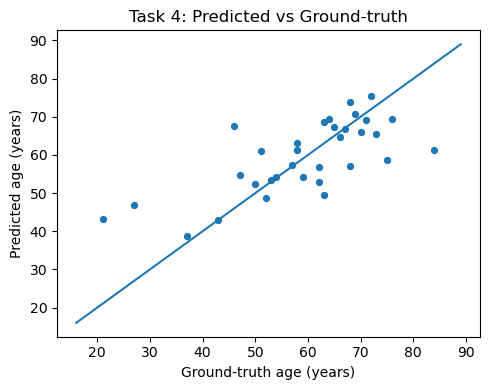

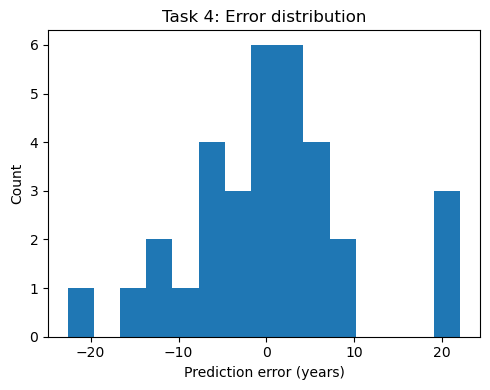

[Task 3] Wrote predictions to: /scratch/hdharmen/ASU/CSE 507/data/jsrt/age_predictions_test.csv


In [13]:
def evaluate_age_years(model, loader, clamp_to=(16, 89)):
    model.eval(); preds=[]; gts=[]
    lo, hi = clamp_to
    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE)
            p_years = (model(x).squeeze(1) * age_std + age_mean).cpu().numpy()
            preds.extend(p_years.tolist()); gts.extend(y.squeeze(1).numpy().tolist())
    preds = np.array(preds); gts = np.array(gts)
    if clamp_to is not None:
        preds = np.clip(preds, lo, hi)  # clamp only for reporting
    mae  = np.abs(preds - gts).mean()
    rmse = np.sqrt(((preds - gts)**2).mean())
    return mae, rmse

mae, rmse = evaluate_age_years(model_3, ld_te_3)
print(f"[Task 3] Test MAE: {mae:.2f} yrs | RMSE: {rmse:.2f} yrs")
# --- Optional TTA eval (original + horizontal flip) ---
def evaluate_age_years_tta(model, loader, clamp_to=(16, 89)):
    model.eval(); preds=[]; gts=[]
    lo, hi = clamp_to if clamp_to else (None, None)
    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE)
            p1 = model(x).squeeze(1)
            p2 = model(torch.flip(x, dims=[3])).squeeze(1)  # H-flip
            p = 0.5 * (p1 + p2)
            p_years = (p * age_std + age_mean).cpu().numpy()
            preds.extend(p_years.tolist())
            gts.extend(y.squeeze(1).numpy().tolist())
    preds = np.array(preds); gts = np.array(gts)
    if clamp_to is not None:
        preds = np.clip(preds, lo, hi)
    mae  = np.abs(preds - gts).mean()
    rmse = np.sqrt(((preds - gts)**2).mean())
    return mae, rmse

mae_tta, rmse_tta = evaluate_age_years_tta(model_3, ld_te_3)
print(f"[Task 3-TTA] Test MAE: {mae_tta:.2f} yrs | RMSE: {rmse_tta:.2f} yrs")

# --- Pretty results: R^2, Pearson r, plots, CSV ---
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import csv

def collect_preds_years(model, loader):
    model.eval(); preds=[]; gts=[]
    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE)
            p_years = (model(x).squeeze(1) * age_std + age_mean).cpu().numpy()
            preds.extend(p_years.tolist()); gts.extend(y.squeeze(1).numpy().tolist())
    return np.array(preds), np.array(gts)

preds, gts = collect_preds_years(model_3, ld_te_3)
preds_clip = np.clip(preds, 16, 89)

mae  = np.abs(preds_clip - gts).mean()
rmse = np.sqrt(((preds_clip - gts)**2).mean())
r2   = r2_score(gts, preds_clip)
corr = np.corrcoef(gts, preds_clip)[0,1]

print("\n[Task 3] Summary")
print(f"  Test MAE  : {mae:.2f} yrs")
print(f"  Test RMSE : {rmse:.2f} yrs")
print(f"  R^2       : {r2:.3f}")
print(f"  Pearson r : {corr:.3f}")

# Scatter: predicted vs ground-truth
plt.figure(figsize=(5,4))
plt.scatter(gts, preds_clip, s=18)
plt.plot([16, 89], [16, 89])
plt.xlabel("Ground-truth age (years)")
plt.ylabel("Predicted age (years)")
plt.title("Task 4: Predicted vs Ground-truth")
plt.tight_layout()
plt.show()

# Error histogram
plt.figure(figsize=(5,4))
errors = preds_clip - gts
plt.hist(errors, bins=15)
plt.xlabel("Prediction error (years)")
plt.ylabel("Count")
plt.title("Task 4: Error distribution")
plt.tight_layout()
plt.show()

# Save predictions CSV
pred_csv = BASE_DIR / "age_predictions_test.csv"
with open(pred_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["index","y_true","y_pred","error"])
    for i,(t,p) in enumerate(zip(gts, preds_clip)):
        w.writerow([i, float(t), float(p), float(p-t)])
print(f"[Task 3] Wrote predictions to: {pred_csv}")



In [10]:
# --- Segmentation datasets (Task 4–6) ---
DATASETS.update({
    "Segmentation01": "http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/11/Segmentation01.zip",  # lungs
    "Segmentation02": "http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2019/07/segmentation02.zip",  # organs (instances/bboxes)
})

seg1_dir = download_if_needed("Segmentation01", DATASETS["Segmentation01"])
seg2_dir = download_if_needed("Segmentation02", DATASETS["Segmentation02"])  # needed for Tasks 5–6

print("[Seg1]", seg1_dir)
print("[Seg2]", seg2_dir)



[Segmentation01] ready at /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation01
[Segmentation02] ready at /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02
[Seg1] /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation01
[Seg2] /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02


In [5]:
# --- ResNet-18 → simple FCN-32s head (returns logits [N,C,H,W]) ---
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F

def build_fcn_resnet18(num_classes: int, freeze_backbone: bool = True):
    m = resnet18(weights=ResNet18_Weights.DEFAULT)
    # backbone up to layer4
    backbone = torch.nn.Sequential(
        m.conv1, m.bn1, m.relu, m.maxpool,
        m.layer1, m.layer2, m.layer3, m.layer4
    )
    if freeze_backbone:
        for p in backbone.parameters(): p.requires_grad = False
    head = torch.nn.Conv2d(512, num_classes, kernel_size=1)
    model = torch.nn.Module()
    model.backbone = backbone
    model.head = head
    def forward(x):
        feat = model.backbone(x)             # [N,512,H/32,W/32]
        logits = model.head(feat)            # [N,C,H/32,W/32]
        logits = F.interpolate(logits, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return logits
    model.forward = forward
    return model.to(DEVICE)


In [21]:
# --- Helper: try to find "images" and "masks" dirs under train/ and test/ ---
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF

def _find_subdir(root, part, key_words):
    base = root / part
    if not base.exists(): return None
    # prefer explicit subdirs
    for k in key_words:
        c = next((p for p in base.rglob("*") if p.is_dir() and k in p.name.lower()), None)
        if c: return c
    # fallback: the part itself has images/masks mixed -> return part
    return base

def _pair_by_stem(img_dir, mask_dir, img_exts=(".png",".jpg",".jpeg",".bmp"), mask_exts=(".png",".bmp")):
    images = [p for p in img_dir.rglob("*") if p.suffix.lower() in img_exts]
    mask_lookup = {}
    for q in mask_dir.rglob("*"):
        if q.suffix.lower() in mask_exts:
            mask_lookup[q.stem.lower()] = q
    pairs = []
    for ip in images:
        mp = mask_lookup.get(ip.stem.lower())
        if mp: pairs.append((ip, mp))
    if not pairs:
        raise FileNotFoundError(f"No img/mask pairs under {img_dir} ↔ {mask_dir}")
    return pairs

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class LungSegDataset(Dataset):
    def __init__(self, pairs, size=384, augment=False):
        self.pairs = pairs
        self.size = size
        self.augment = augment

    def __len__(self): 
        return len(self.pairs)

    def __getitem__(self, i):
        ip, mp = self.pairs[i]
        img  = Image.open(ip).convert("L")
        mask = Image.open(mp)
        # strip constant borders (JSRT corner tags / film borders)
        a = np.array(img, dtype=np.uint8)
        # detect top/bottom rows that are near-constant
        def _trim(v, thr=3):
            i0, i1 = 0, v.shape[0]-1
            while i0 < i1 and v[i0].max()-v[i0].min() <= thr: i0 += 1
            while i1 > i0 and v[i1].max()-v[i1].min() <= thr: i1 -= 1
            return i0, i1+1
        r0, r1 = _trim(a); c0, c1 = _trim(a.T)
        a = a[r0:r1, c0:c1]; img = Image.fromarray(a)
        mask = mask.crop((c0, r0, c1, r1))


        # resize first (keep same for img & mask)
        img  = TF.resize(img,  (self.size, self.size), InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (self.size, self.size), InterpolationMode.NEAREST)

        # optional simple aug
        if self.augment and random.random() < 0.5:
            img  = TF.hflip(img)
            mask = TF.hflip(mask)

        # to tensors
        x1 = TF.to_tensor(img)[0:1]
        x1 = (x1 - x1.mean()) / (x1.std() + 1e-6)
        x  = x1.repeat(3,1,1)

        # some masks in JSRT are 0 / 255; threshold at 128
        m = (np.array(mask, dtype=np.uint8) >= 128).astype(np.int64)
        m = torch.from_numpy(m)
        return x, m

class OrganSegDataset(Dataset):
    """
    Multi-class organ masks (instance-by-class, e.g., background=0, left_lung=1, right_lung=2, heart=3, ...).
    Assumes mask pixel values already encode classes; if they are 0/255 per organ, merge beforehand or adjust here.
    """
    def __init__(self, pairs, size=256):
        self.pairs = pairs
        self.size = size
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        ip, mp = self.pairs[i]
        img  = Image.open(ip).convert("L")
        mask = Image.open(mp)  # keep as P/L; unique values = classes
        img  = TF.resize(img,  (self.size, self.size), InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (self.size, self.size), InterpolationMode.NEAREST)
        x = TF.to_tensor(img).repeat(3,1,1)
        x = TF.normalize(x, IMAGENET_MEAN, IMAGENET_STD)
        m = torch.from_numpy(np.array(mask, dtype=np.int64))
        # If mask is {0,255} for each organ channel separately, change this to your merge logic.
        return x, m
    
# Put this near your other helpers
import numpy as np
from skimage import measure, morphology
from scipy.ndimage import distance_transform_edt as dist_edt

def semantic_to_instances_lr_heart(lbl2d, lung_id=1, heart_id=2):
    """
    lbl2d: HxW semantic labels (0=bg, lung_id=lungs, heart_id=heart)
    returns dict of binary masks: {'left_lung','right_lung','heart'}
    """
    H, W = lbl2d.shape
    out = {'left_lung': np.zeros((H,W), bool),
           'right_lung': np.zeros((H,W), bool),
           'heart': (lbl2d == heart_id)}

    lungs = (lbl2d == lung_id)
    if lungs.any():
        # split connected components; keep two largest
        labeled = measure.label(lungs)
        props = sorted(measure.regionprops(labeled), key=lambda r: r.area, reverse=True)
        if len(props) >= 2:
            a, b = props[0].label, props[1].label
            compA, compB = (labeled == a), (labeled == b)
        else:
            # single blob: split by watershed over distance to center seam
            d = dist_edt(lungs)
            # vertical seam prior: left vs right of image center
            xgrid = np.tile(np.arange(W), (H,1))
            left_prior  = (xgrid < W//2).astype(np.float32)
            right_prior = 1.0 - left_prior
            left_score  = d + left_prior*2.0
            right_score = d + right_prior*2.0
            compA = (left_score  >= right_score) & lungs
            compB = (right_score >  left_score) & lungs

        # decide which is left/right by centroid x
        def centroid_x(mask):
            ys, xs = np.nonzero(mask)
            return xs.mean() if xs.size else 0
        if centroid_x(compA) <= centroid_x(compB):
            out['left_lung']  = morphology.remove_small_holes(compA, area_threshold=128)
            out['right_lung'] = morphology.remove_small_holes(compB, area_threshold=128)
        else:
            out['left_lung']  = morphology.remove_small_holes(compB, area_threshold=128)
            out['right_lung'] = morphology.remove_small_holes(compA, area_threshold=128)
    return out



In [7]:
# --- Segmentation training + mIoU ---
def train_seg(model, train_loader, val_loader=None, epochs=15, lr=1e-3, num_classes=2):
    crit = nn.CrossEntropyLoss()
    opt  = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    for ep in range(1, epochs+1):
        model.train(); tot=0
        for x,y in train_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            logits = model(x)                  # [N,C,H,W]
            loss = crit(logits, y.long())
            loss.backward(); opt.step()
            tot += loss.item()*x.size(0)
        msg = f"[Seg] E{ep:02d} train {tot/len(train_loader.dataset):.4f}"
        if val_loader:
            mi = mean_iou_seg(model, val_loader, num_classes)
            msg += f" | mIoU {mi:.3f}"
        print(msg)

def mean_iou_seg(model, loader, num_classes):
    model.eval(); ious=[]; 
    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE)
            pred = model(x).argmax(1).cpu()   # [N,H,W]
            y    = y.long()
            for p,t in zip(pred, y):
                scores=[]
                for c in range(num_classes):
                    P = (p==c); T = (t==c)
                    inter = (P & T).sum().item()
                    union = (P | T).sum().item()
                    if union>0: scores.append(inter/union)
                if scores: ious.append(sum(scores)/len(scores))
    return (sum(ious)/len(ious)) if ious else 0.0


In [25]:
# ===================== Task 4: Better lung segmentation (DeepLabV3-R50) =====================
# - Paired augmentations (geom) + image-only intensity jitter
# - DeepLabV3-ResNet50 (COCO-pretrained), binary 1-logit head
# - Loss: 0.5 * BCEWithLogits + 0.5 * Dice
# - Post-process: keep two largest components + fill holes
# - mIoU computed on post-processed predictions
# ============================================================================================

import random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

# ---- device ----
if "DEVICE" not in globals():
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- imagenet normalization ----
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# ------------------------------- Dataset with paired augments --------------------------------
class LungSegDataset(Dataset):
    def __init__(self, pairs, size=512, augment=False):
        self.pairs = pairs
        self.size = size
        self.augment = augment

    def __len__(self): return len(self.pairs)

    def _paired_affine(self, img, mask):
        angle = random.uniform(-7, 7)
        translate = (random.uniform(-0.05, 0.05)*img.width,
                     random.uniform(-0.05, 0.05)*img.height)
        scale = random.uniform(0.92, 1.08)
        shear = 0.0
        img  = TF.affine(img, angle=angle, translate=translate, scale=scale, shear=shear,
                         interpolation=InterpolationMode.BILINEAR)
        mask = TF.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear,
                         interpolation=InterpolationMode.NEAREST)
        return img, mask

    def __getitem__(self, i):
        ip, mp = self.pairs[i]
        img  = Image.open(ip).convert("L")
        mask = Image.open(mp)

        # resize first (consistent for both)
        img  = TF.resize(img,  (self.size, self.size), InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (self.size, self.size), InterpolationMode.NEAREST)

        if self.augment:
            if random.random() < 0.5:
                img  = TF.hflip(img); mask = TF.hflip(mask)
            if random.random() < 0.8:
                img, mask = self._paired_affine(img, mask)
            # image-only intensity jitter
            if random.random() < 0.5:
                img = TF.adjust_gamma(img, gamma=random.uniform(0.8, 1.2))
            if random.random() < 0.5:
                img = TF.adjust_contrast(img, contrast_factor=random.uniform(0.8, 1.25))

        x = TF.to_tensor(img).repeat(3, 1, 1)
        x = TF.normalize(x, IMAGENET_MEAN, IMAGENET_STD)

        # robust binarization (0/255 masks)
        m = torch.from_numpy((np.array(mask, dtype=np.uint8) >= 128).astype(np.int64))
        return x, m

# ------------------------------- Model: DeepLabV3-ResNet50 -----------------------------------
def build_deeplab50(num_classes=1, freeze_backbone=True):
    m = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
    # Replace final classifier conv to 1 logit (foreground)
    m.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
    if freeze_backbone:
        for p in m.backbone.parameters(): p.requires_grad = False
    return m.to(DEVICE)

# ------------------------------- Losses ------------------------------------------------------
def dice_loss_from_logits_binary(logits, target):
    # logits: [N,1,H,W], target: [N,H,W] in {0,1}
    probs = torch.sigmoid(logits).squeeze(1)  # [N,H,W]
    target = target.float()
    smooth = 1.0
    inter  = (probs * target).sum(dim=(1,2))
    union  = probs.sum(dim=(1,2)) + target.sum(dim=(1,2))
    dice   = (2*inter + smooth) / (union + smooth)
    return 1 - dice.mean()

# ------------------------------- Post-processing --------------------------------------------
def postprocess_keep_2_lungs(pred_prob, thresh=0.5):
    """
    pred_prob: float tensor [H,W] in [0,1] -> returns uint8 mask {0,1}
    Keeps two largest connected components and fills holes.
    """
    binm = (pred_prob >= thresh).to(torch.uint8).cpu().numpy()
    try:
        from scipy import ndimage as ndi
        lab, n = ndi.label(binm)
        if n > 2:
            sizes = ndi.sum(binm, lab, index=range(1, n+1))
            keep = np.argsort(sizes)[-2:] + 1
            binm = np.isin(lab, keep).astype(np.uint8)
        binm = ndi.binary_fill_holes(binm, structure=np.ones((3,3))).astype(np.uint8)
    except Exception:
        # fallback hole fill via maxpool "closing"
        t = torch.from_numpy(binm)[None,None].float()
        t = F.max_pool2d(t, kernel_size=5, stride=1, padding=2)
        binm = (t[0,0] > 0.5).to(torch.uint8).numpy()
    return binm

# ------------------------------- Metrics -----------------------------------------------------
def mean_iou_binary(model, loader):
    model.eval(); ious=[]
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE); yb = yb.cpu().numpy()
            out  = model(xb)['out']              # [N,1,H,W]
            prob = torch.sigmoid(out).cpu()      # [N,1,H,W]
            for i in range(prob.size(0)):
                pm = postprocess_keep_2_lungs(prob[i,0])
                tm = yb[i].astype(np.uint8)
                inter = (pm & tm).sum()
                union = (pm | tm).sum()
                if union > 0: ious.append(inter/union)
    return float(np.mean(ious)) if ious else 0.0

# ------------------------------- Training ----------------------------------------------------
def train_seg_binary(model, train_loader, val_loader=None, epochs=40,
                     lr_head=3e-4, lr_backbone=1e-4, unfreeze_at=12):
    bce = nn.BCEWithLogitsLoss()
    # start with head-only params (backbone frozen)
    head_params = [p for n,p in model.named_parameters() if p.requires_grad and not n.startswith("backbone")]
    opt = torch.optim.AdamW([{"params": head_params, "lr": lr_head}])

    for ep in range(1, epochs+1):
        # unfreeze backbone after warmup
        if ep == unfreeze_at:
            for p in model.backbone.parameters(): p.requires_grad = True
            opt.add_param_group({"params": model.backbone.parameters(), "lr": lr_backbone})

        model.train(); run_loss=0.0; nimg=0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE).float()  # [N,H,W]
            out = model(xb)['out'].squeeze(1)               # [N,H,W]
            loss = 0.5*bce(out, yb) + 0.5*dice_loss_from_logits_binary(out.unsqueeze(1), yb)
            opt.zero_grad(); loss.backward(); opt.step()
            run_loss += loss.item() * xb.size(0); nimg += xb.size(0)

        msg = f"[DeepLab] E{ep:02d} train {run_loss/max(1,nimg):.4f}"
        if val_loader is not None:
            miou = mean_iou_binary(model, val_loader)
            msg += f" | mIoU {miou:.3f}"
        print(msg)

# ------------------------------- Use it ------------------------------------------------------
# Requires: pairs_tr_1, pairs_te_1 already built from Segmentation01 lists.
if 'pairs_tr_1' not in globals() or 'pairs_te_1' not in globals():
    raise RuntimeError("pairs_tr_1 / pairs_te_1 are not defined. Build them from Segmentation01 first.")

# Loaders (bigger size helps DeepLab receptive field)
ds_tr_4 = LungSegDataset(pairs_tr_1, size=512, augment=True)
ds_te_4 = LungSegDataset(pairs_te_1, size=512, augment=False)
ld_tr_4 = DataLoader(ds_tr_4, batch_size=6, shuffle=True,  num_workers=2, pin_memory=True)
ld_te_4 = DataLoader(ds_te_4, batch_size=6, shuffle=False, num_workers=2, pin_memory=True)

# Build, train, evaluate
model_4 = build_deeplab50(num_classes=1, freeze_backbone=True)
train_seg_binary(model_4, ld_tr_4, ld_te_4, epochs=40, lr_head=3e-4, lr_backbone=1e-4, unfreeze_at=12)
print(f"[Task 4] Test mIoU (post-processed): {mean_iou_binary(model_4, ld_te_4):.3f}")


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /home/hdharmen/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 128MB/s]  


[DeepLab] E01 train 0.4140 | mIoU 0.801
[DeepLab] E02 train 0.2185 | mIoU 0.839
[DeepLab] E03 train 0.1780 | mIoU 0.843
[DeepLab] E04 train 0.1547 | mIoU 0.867
[DeepLab] E05 train 0.1468 | mIoU 0.862
[DeepLab] E06 train 0.1310 | mIoU 0.890
[DeepLab] E07 train 0.1197 | mIoU 0.907
[DeepLab] E08 train 0.1073 | mIoU 0.913
[DeepLab] E09 train 0.1019 | mIoU 0.920
[DeepLab] E10 train 0.0969 | mIoU 0.913
[DeepLab] E11 train 0.0951 | mIoU 0.920
[DeepLab] E12 train 0.0882 | mIoU 0.888
[DeepLab] E13 train 0.0711 | mIoU 0.948
[DeepLab] E14 train 0.0640 | mIoU 0.948
[DeepLab] E15 train 0.0593 | mIoU 0.956
[DeepLab] E16 train 0.0552 | mIoU 0.949
[DeepLab] E17 train 0.0520 | mIoU 0.959
[DeepLab] E18 train 0.0487 | mIoU 0.959
[DeepLab] E19 train 0.0469 | mIoU 0.956
[DeepLab] E20 train 0.0436 | mIoU 0.962
[DeepLab] E21 train 0.0413 | mIoU 0.963
[DeepLab] E22 train 0.0398 | mIoU 0.965
[DeepLab] E23 train 0.0383 | mIoU 0.964
[DeepLab] E24 train 0.0372 | mIoU 0.966
[DeepLab] E25 train 0.0361 | mIoU 0.964


In [ ]:
# ---- Task 4: export "image | GT | prediction" triptychs (works with DeepLab/FCN) ----
import numpy as np
from PIL import Image
from pathlib import Path
import torch
from collections import OrderedDict

def _denorm_to_u8(x3chw):
    x = x3chw.detach().cpu().numpy().transpose(1, 2, 0)
    x = (x * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)).clip(0, 1)
    return (x[..., 0] * 255).astype(np.uint8)   # grayscale repeated to 3ch

def _binmask_to_u8(m):
    return (m.astype(np.uint8) * 255)

def _triptych_u8(img_u8, gt_u8, pr_u8, pad=6):
    h, w = img_u8.shape
    canvas = np.zeros((h, w * 3 + 2 * pad), dtype=np.uint8)
    canvas[:, 0:w] = img_u8
    canvas[:, w + pad:w * 2 + pad] = gt_u8
    canvas[:, w * 2 + 2 * pad:] = pr_u8
    return Image.fromarray(canvas)

# optional: keep two largest components + fill holes (helps lungs look clean)
def _postprocess_keep_two(bin_mask):
    try:
        from scipy import ndimage as ndi
        lab, n = ndi.label(bin_mask)
        if n > 2:
            sizes = ndi.sum(bin_mask, lab, index=range(1, n+1))
            keep = np.argsort(sizes)[-2:] + 1
            bin_mask = np.isin(lab, keep).astype(np.uint8)
        bin_mask = ndi.binary_fill_holes(bin_mask, structure=np.ones((3,3))).astype(np.uint8)
    except Exception:
        pass
    return bin_mask

@torch.no_grad()
def export_seg1_triptychs(model, loader, out_dir: Path, max_n=12, apply_post=True, thresh=0.5):
    out_dir.mkdir(parents=True, exist_ok=True)
    n = 0
    model.eval()
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        out = model(xb)
        # handle dict (torchvision) vs tensor (custom)
        if isinstance(out, (dict, OrderedDict)):
            logits = out['out']
        else:
            logits = out

        if logits.shape[1] == 1:
            # binary head -> sigmoid
            prob = torch.sigmoid(logits).squeeze(1).cpu().numpy()  # [N,H,W]
            pred = (prob >= thresh).astype(np.uint8)
        else:
            # multi-class head -> argmax
            pred = logits.argmax(1).detach().cpu().numpy().astype(np.uint8)

        for i in range(xb.size(0)):
            img_u8 = _denorm_to_u8(xb[i].cpu())
            gt_u8  = _binmask_to_u8((yb[i].cpu().numpy() > 0).astype(np.uint8))
            pr_bin = pred[i]
            # if multi-class, treat any non-zero as foreground for viz
            if pr_bin.ndim == 2 and pr_bin.max() > 1:
                pr_bin = (pr_bin > 0).astype(np.uint8)
            if apply_post:
                pr_bin = _postprocess_keep_two(pr_bin)
            pr_u8  = _binmask_to_u8(pr_bin)
            panel  = _triptych_u8(img_u8, gt_u8, pr_u8, pad=8)
            panel.save(out_dir / f"seg1_{n:03d}.png")
            n += 1
            if n >= max_n:
                return

# save examples from TEST loader
seg1_vis_dir = seg1_dir / "result"
export_seg1_triptychs(model_4, ld_te_4, seg1_vis_dir, max_n=12, apply_post=True, thresh=0.5)
print("Saved triptychs to:", seg1_vis_dir)


NameError: name 'seg1_dir' is not defined

In [22]:
# ===== Task 5: Organ multi-class segmentation (Segmentation02) — FINAL safe drop-in =====
import os, gc, re, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from collections import Counter

# used by post-processing / splitting and grayscale export
import cv2
from scipy import ndimage


# ---------- Device (auto CPU fallback if CUDA is in a bad state) ----------
os.environ.setdefault("CUDA_LAUNCH_BLOCKING", "1")

def get_device():
    if torch.cuda.is_available():
        try:
            _ = torch.ones(1, device="cuda").sum().item()
            torch.cuda.synchronize()
            print("[Device] CUDA OK -> using GPU")
            return torch.device("cuda")
        except Exception as e:
            print(f"[Device] CUDA not usable due to prior device assert: {e}\n[Device] Falling back to CPU.")
    return torch.device("cpu")

DEVICE = get_device()
# ---- HARD-DISABLE CUDA FOR THIS RUN IF WE FELL BACK TO CPU ----
if DEVICE.type == "cpu" and torch.cuda.is_available():
    print("[Device] Disabling CUDA APIs for this run (poisoned context).")
    # Make PyTorch think CUDA isn't available so optimizers don't touch CUDA at all
    #torch.cuda.is_available = lambda: False  # type: ignore[misc]
    # Belt & suspenders: stub this too in case any lib calls it
    try:
        torch.cuda.is_current_stream_capturing = lambda: False  # type: ignore[attr-defined]
    except Exception:
        pass


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
IGNORE = 255

# ---------- Data root ----------
DATASETS.setdefault("Segmentation02", "http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2018/11/Segmentation02.zip")
seg2_dir = download_if_needed("Segmentation02", DATASETS["Segmentation02"])

# ---------- Folder discovery ----------
IMG_EXTS  = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
MASK_EXTS = (".png", ".bmp", ".tif", ".tiff")

def _score_path(p: Path, tokens):
    s = p.as_posix().lower()
    return sum(t in s for t in tokens)

def _find_split_dir(root: Path, split: str, kind: str):
    split_tokens = {"train": ["train"], "test": ["test"]}[split]
    if kind == "org":
        kind_tokens = ["org", "image", "images", "img"]; file_exts = IMG_EXTS
    else:
        kind_tokens = ["label", "labels", "mask", "masks"]; file_exts = MASK_EXTS
    cands = [d for d in root.rglob("*") if d.is_dir()]
    filtered = []
    for d in cands:
        if any(q.is_file() and q.suffix.lower() in file_exts for q in d.rglob("*")):
            filtered.append(d)
    filtered.sort(key=lambda d: (_score_path(d, split_tokens)+2*_score_path(d, kind_tokens), -len(d.as_posix())),
                  reverse=True)
    return filtered[0] if filtered else None

org_tr = _find_split_dir(seg2_dir, "train", "org")
lab_tr = _find_split_dir(seg2_dir, "train", "label")
org_te = _find_split_dir(seg2_dir, "test",  "org")
lab_te = _find_split_dir(seg2_dir, "test",  "label")

if not (org_tr and lab_tr and org_te and lab_te):
    raise RuntimeError(f"Could not locate Segmentation02 subfolders.\nroot={seg2_dir}")

print("[Seg2] Folders:\n  org_tr:", org_tr, "\n  lab_tr:", lab_tr, "\n  org_te:", org_te, "\n  lab_te:", lab_te)

# ---------- Pairing ----------
def _stem_key(p: Path):
    stem = p.stem.lower()
    digits = "".join(ch for ch in stem if ch.isdigit())
    return digits if digits else stem

def pair_seg2(img_dir: Path, mask_dir: Path):
    imgs  = [p for p in img_dir.rglob("*") if p.is_file() and p.suffix.lower() in IMG_EXTS]
    masks = [p for p in mask_dir.rglob("*") if p.is_file() and p.suffix.lower() in MASK_EXTS]
    if not imgs:  raise RuntimeError(f"No images found under {img_dir}")
    if not masks: raise RuntimeError(f"No masks found under {mask_dir}")
    m_by_key = {}
    for q in masks:
        m_by_key.setdefault(_stem_key(q), []).append(q)
    pairs, misses = [], []
    for ip in imgs:
        cand = m_by_key.get(_stem_key(ip))
        if cand:
            cand.sort(key=lambda q: abs(len(q.stem)-len(ip.stem)))
            pairs.append((ip, cand[0]))
        else:
            misses.append(ip.name)
    print(f"[Seg2] {len(pairs)} pairs built | {len(misses)} unmatched from {img_dir.name}")
    if pairs:
        print("       example:", pairs[0][0].relative_to(seg2_dir), "<->", pairs[0][1].relative_to(seg2_dir))
    if not pairs: raise RuntimeError(f"No img↔mask pairs from {img_dir} and {mask_dir}")
    return pairs

pairs_tr_2 = pair_seg2(org_tr, lab_tr)
pairs_te_2 = pair_seg2(org_te, lab_te)
print(f"[Seg2] final -> train={len(pairs_tr_2)} | test={len(pairs_te_2)}")


# --- Model: DeepLabV3 ResNet50 with aux head and logits-only wrapper ---
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
def build_deeplabv3(num_classes, freeze_backbone=False, pretrained=True):
    m = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT, aux_loss=True)


    # Replace heads to match our num_classes
    m.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
    if m.aux_classifier is not None:
        m.aux_classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

    if freeze_backbone:
        for p in m.backbone.parameters():
            p.requires_grad = False

    return m  # NOTE: returns model with dict output: {'out': logits, 'aux': aux_logits}
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items() if v.dtype.is_floating_point}
    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1-self.decay)
    @torch.no_grad()
    def apply_to(self, model):
        sd = model.state_dict()
        sd.update({k: v for k, v in self.shadow.items()})
        model.load_state_dict(sd)



# ---------- Label LUT (contiguous 0..K-1; keep IGNORE=255) ----------
def build_label_lut_auto_bg(pairs_a, pairs_b=None, ignore_index=255, sample=800):
    """
    Scan masks, detect which raw code is 'background' as the most frequent value,
    then map: bg_code -> 0 (background), every other seen code -> 1..K-1.
    Unseen codes -> ignore_index.
    """
    counts = Counter()
    uniq = set()
    all_pairs = list(pairs_a) + (list(pairs_b) if pairs_b else [])
    for _, mp in all_pairs[:sample]:
        arr = np.array(Image.open(mp))
        uniq.update(np.unique(arr).tolist())
        # count frequencies (skip ignore)
        if ignore_index in uniq:
            pass
        vals, freqs = np.unique(arr[arr != ignore_index], return_counts=True)
        counts.update(dict(zip(vals.tolist(), freqs.tolist())))

    # Remove ignore from uniq set if present
    if ignore_index in uniq:
        uniq.discard(ignore_index)

    if not counts:
        raise RuntimeError("Could not compute frequencies; check your masks.")

    # Heuristic: background is the most frequent code
    bg_code = max(counts.items(), key=lambda kv: kv[1])[0]

    # Foreground are all other seen codes
    fg_codes = sorted([v for v in uniq if v != bg_code])

    max_code = max([ignore_index] + (list(uniq) if uniq else [0]))
    lut = np.full(max_code + 1, ignore_index, dtype=np.int64)
    lut[bg_code] = 0
    for new_i, orig in enumerate(fg_codes, start=1):
        lut[orig] = new_i

    n_classes = 1 + len(fg_codes)
    # Pretty print
    mapping_preview = {int(bg_code): 0}
    for orig in fg_codes:
        mapping_preview[int(orig)] = int(lut[orig])
    print("[Seg2][LUT] uniq codes:", sorted(map(int, uniq)))
    print("[Seg2][LUT] inferred bg_code:", int(bg_code))
    print("[Seg2][LUT] mapping (orig -> new):", mapping_preview)
    print("[Seg2][LUT] n_classes (incl. background):", n_classes)

    # Sanity: background should be majority after remap
    if counts[bg_code] < 0.4 * sum(counts.values()):
        print("[Seg2][WARN] Background not dominant—double-check the masks/labels.")
    return lut, n_classes

lut_np, n_classes = build_label_lut_auto_bg(pairs_tr_2, pairs_te_2, ignore_index=IGNORE)
# after: lut_np, n_classes = build_label_lut_auto_bg(...)
LUNG_ID, HEART_ID = infer_roles(pairs_tr_2 + pairs_te_2, lut_np, n_classes, ignore_index=IGNORE)


def infer_roles(pairs, lut_np, n_classes, ignore_index=IGNORE, sample=400):
    """Decide which remapped id is lung vs heart by area (lung >> heart)."""
    counts = np.zeros(n_classes, dtype=np.int64)
    for _, mp in pairs[:sample]:
        arr = np.array(Image.open(mp), dtype=np.int64)
        arr = lut_np[arr]
        arr = arr[arr != ignore_index]
        if arr.size == 0: 
            continue
        counts += np.bincount(arr, minlength=n_classes)
    # foreground only
    fg = counts[1:]
    if len(fg) != 2:
        raise RuntimeError(f"Expected 2 foreground classes, got {len(fg)} with counts {counts.tolist()}")
    lung_id  = 1 + int(np.argmax(fg))   # larger area
    heart_id = 1 + int(np.argmin(fg))   # smaller area
    print(f"[Seg2] Role inference: bg=0, lung_id={lung_id}, heart_id={heart_id}, counts={counts.tolist()}")
    return lung_id, heart_id

# Use both train and test to be robust
LUNG_ID, HEART_ID = infer_roles(pairs_tr_2 + pairs_te_2, lut_np, n_classes, ignore_index=IGNORE)

from torch.utils.data.sampler import WeightedRandomSampler

def _sample_weights(ds, k=5):
    # upweight masks with SMALL heart and LARGE boundary length
    ws = []
    for _, mp in ds.pairs:
        m = np.array(Image.open(mp))
        heart = (m == 0).astype(np.uint8)
        lungs = (m == 85).astype(np.uint8)
        # proxy for boundary: gradient magnitude of lungs + heart
        edge = cv2.Canny((lungs*255 + heart*255).astype(np.uint8), 50, 150)
        w = 1.0 + 2.0*(heart.sum() < 20000) + 1.0*(edge.sum()/(255) > 2000)
        ws.append(w)
    ws = np.asarray(ws, np.float32); ws /= ws.mean()
    return torch.as_tensor(ws, dtype=torch.double)


sampler_tr = WeightedRandomSampler(_sample_weights(ds_tr_5), num_samples=len(ds_tr_5), replacement=True)
ld_tr_5 = DataLoader(ds_tr_5, batch_size=4, sampler=sampler_tr, drop_last=True, num_workers=2 if pin else 0, pin_memory=pin)



# ---------- Dataset & loaders ----------
class OrganSegDataset(Dataset):
    def __init__(self, pairs, lut_np, size=384, augment=True, ignore_index=IGNORE):
        self.pairs = pairs
        self.size = size
        self.augment = augment
        self.ignore_index = ignore_index
        self.lut = lut_np
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        ip, mp = self.pairs[i]
        img  = Image.open(ip).convert("L")
        mask = Image.open(mp)
        def _letterbox(im_pil, sz, mode_img=InterpolationMode.BILINEAR, mode_mask=InterpolationMode.NEAREST):
            w, h = im_pil.size
            scale = min(sz / h, sz / w)
            nh, nw = int(round(h * scale)), int(round(w * scale))
            im_res = TF.resize(im_pil, (nh, nw), mode_img)
            pad_t = (sz - nh) // 2; pad_b = sz - nh - pad_t
            pad_l = (sz - nw) // 2; pad_r = sz - nw - pad_l
            im_pad = TF.pad(im_res, [pad_l, pad_t, pad_r, pad_b], fill=0)
            return im_pad

        def _letterbox_mask(msk_pil, sz):
            w, h = msk_pil.size
            scale = min(sz / h, sz / w)
            nh, nw = int(round(h * scale)), int(round(w * scale))
            m_res = TF.resize(msk_pil, (nh, nw), InterpolationMode.NEAREST)
            pad_t = (sz - nh) // 2; pad_b = sz - nh - pad_t
            pad_l = (sz - nw) // 2; pad_r = sz - nw - pad_l
            m_pad = TF.pad(m_res, [pad_l, pad_t, pad_r, pad_b], fill=IGNORE)
            return m_pad

        img  = _letterbox(img,  self.size)
        mask = _letterbox_mask(mask, self.size)
        if self.augment:
            if np.random.rand() < 0.5:
                img = TF.hflip(img); mask = TF.hflip(mask)
            # mild affine (no shear to avoid anatomy distortion)
            if np.random.rand() < 0.25:
                ang = float(np.random.uniform(-4, 4))
                tx  = float(np.random.uniform(-0.02, 0.02) * img.size[1])
                img = TF.affine(img, angle=ang, translate=(tx,0), scale=1.0, shear=0,
                                interpolation=InterpolationMode.BILINEAR)
                mask= TF.affine(mask, angle=ang, translate=(tx,0), scale=1.0, shear=0,
                                interpolation=InterpolationMode.NEAREST)
            # intensity jitter (gamma + slight brightness)
            if np.random.rand() < 0.35:
                g = float(np.random.uniform(0.8, 1.2))
                img = TF.adjust_gamma(img, gamma=g)
            if np.random.rand() < 0.35:
                b = float(np.random.uniform(0.9, 1.1))
                img = TF.adjust_brightness(img, b)
        # CLAHE (contrast) 50% of the time
        if self.augment and np.random.rand() < 0.5:
            a = np.array(img, dtype=np.uint8)
            a = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(a)
            img = Image.fromarray(a)

        x = TF.to_tensor(img).repeat(3,1,1)

        x = TF.normalize(x, IMAGENET_MEAN, IMAGENET_STD)
        m_orig = np.array(mask, dtype=np.int64)
        if m_orig.max() >= self.lut.shape[0]:
            ext = np.full(int(m_orig.max())+1, self.ignore_index, dtype=np.int64)
            ext[:self.lut.shape[0]] = self.lut
            self.lut = ext
        m = self.lut[m_orig]
        return x, torch.from_numpy(m)

pin = (DEVICE.type == "cuda")
ds_tr_5 = OrganSegDataset(pairs_tr_2, lut_np, size=512, augment=True,  ignore_index=IGNORE)
ds_te_5 = OrganSegDataset(pairs_te_2, lut_np, size=384, augment=False, ignore_index=IGNORE)
ld_tr_5 = DataLoader(
    ds_tr_5,
    batch_size=4,
    shuffle=True,
    drop_last=True,               # <- prevents 1-sample BN issues
    num_workers=2 if pin else 0,
    pin_memory=pin,
)
ld_te_5 = DataLoader(ds_te_5, batch_size=4, shuffle=False,
                     num_workers=2 if pin else 0, pin_memory=pin)


# ---------- Class weights ----------
def compute_class_weights_lut(pairs, lut_np, n_classes, ignore_index=IGNORE, sample=300):
    counts = np.zeros(n_classes, dtype=np.float64)
    for _, mp in pairs[:sample]:
        arr = np.array(Image.open(mp), dtype=np.int64)
        if arr.max() >= lut_np.shape[0]:
            ext = np.full(int(arr.max())+1, ignore_index, dtype=np.int64)
            ext[:lut_np.shape[0]] = lut_np
            lut_np = ext
        arr = lut_np[arr]
        arr = arr[arr != ignore_index]
        if arr.size == 0: continue
        counts += np.bincount(arr, minlength=n_classes).astype(np.float64)
    counts = np.maximum(counts, 1.0)
    inv = 1.0 / counts
    inv[0] *= 0.05
    return torch.tensor(inv / inv.mean(), dtype=torch.float32)

class_weights = compute_class_weights_lut(pairs_tr_2, lut_np, n_classes, ignore_index=IGNORE)
print("[Seg2] class weights (remapped):", class_weights.tolist())

# ---------- Fixed Dice (mask ignore BEFORE one-hot; clamp to [0, C-1]) ----------
def soft_dice_mc(logits, target, eps=1e-6, ignore_index=IGNORE):
    C = logits.shape[1]
    probs = torch.softmax(logits, dim=1)

    t = target
    if ignore_index is not None:
        t = torch.where(t == ignore_index, torch.zeros_like(t), t)
    t = t.clamp(0, C-1).long()

    target_1h = torch.zeros_like(probs)
    target_1h.scatter_(1, t.unsqueeze(1), 1.0)

    if ignore_index is not None:
        valid = (target != ignore_index).float().unsqueeze(1)
        probs     = probs * valid
        target_1h = target_1h * valid

    inter = (probs[:, 1:] * target_1h[:, 1:]).sum(dim=(0,2,3))
    denom = (probs[:, 1:] + target_1h[:, 1:]).sum(dim=(0,2,3))
    return 1.0 - ((2*inter + eps) / (denom + eps)).mean()

# Optional: turn semantic mask into per-organ instances for visualization/export
def semantic_to_instances(lbl2d: np.ndarray, class_ids=(1,2,3)):
    try:
        from scipy.ndimage import label as cc_label
    except Exception:
        cc_label = None

    insts = []
    for cid in class_ids:
        m = (lbl2d == cid).astype(np.uint8)
        if m.sum() == 0:
            continue
        if cc_label is None:
            # fallback: single instance
            insts.append((cid, m.astype(bool)))
            continue
        n, comp = cc_label(m)
        for i in range(1, n+1):
            insts.append((cid, (comp == i)))
    return insts

# put near your viz code
GRAY = { "bg":0, "left":85, "heart":160, "right":255 }  # feel free to tweak

def to_gray_mask(lbl2d, mapping):
    out = np.zeros_like(lbl2d, dtype=np.uint8)
    for k,v in mapping.items():  # k is class-id, v is grayscale
        out[lbl2d==k] = v
    return out


def lovasz_softmax_flat(probs, labels, classes='present'):
    # minimal Lovasz-Softmax (multiclass). Assumes probs [P, C], labels [P]
    def lovasz_grad(gt_sorted):
        gts = gt_sorted.sum()
        inter = gts - gt_sorted.cumsum(0)
        union = gts + (1 - gt_sorted).cumsum(0)
        jacc = 1. - inter / union
        if gt_sorted.numel() > 1:
            jacc[1:] = jacc[1:] - jacc[:-1]
        return jacc
    C = probs.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float()
        if classes == 'present' and fg.sum() == 0:
            continue
        pc = probs[:, c]
        errors = (fg - pc).abs()
        errors_sorted, perm = torch.sort(errors, descending=True)
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, lovasz_grad(fg_sorted)))
    return torch.stack(losses).mean() if losses else probs.new_tensor(0.)

def lovasz_softmax(logits, labels, ignore_index=255):
    C = logits.size(1)
    probs = F.softmax(logits, dim=1)
    mask = labels != ignore_index
    probs, labels = probs.permute(0,2,3,1)[mask], labels[mask]
    if probs.numel() == 0: return logits.new_tensor(0.)
    return lovasz_softmax_flat(probs, labels)

@torch.no_grad()
def export_triptych_gray(model, loader, out_dir: Path, ignore_index=255):
    out_dir.mkdir(parents=True, exist_ok=True)
    for xb, yb in loader:
        out = model(xb.to(DEVICE))
        logits = out['out'] if isinstance(out, dict) else out
        pred = logits.argmax(1).cpu().numpy()
        imgs = xb.numpy()
        gts  = yb.numpy()
        for i in range(imgs.shape[0]):
            x = imgs[i,0] * IMAGENET_STD[0] + IMAGENET_MEAN[0]
            x = (x.clip(0,1)*255).astype(np.uint8)
            gt = gts[i].copy(); gt[gt==ignore_index]=0
            pr = pred[i]

            # after you split lungs (section 3), pr will already be {bg=0,left=1,heart=2,right=3}
            gt_gray = to_gray_mask(gt, {0:GRAY["bg"], 1:GRAY["left"], 2:GRAY["heart"], 3:GRAY["right"]})
            pr_gray = to_gray_mask(pr, {0:GRAY["bg"], 1:GRAY["left"], 2:GRAY["heart"], 3:GRAY["right"]})

            h,w = x.shape; pad=6
            canvas = np.zeros((h, 3*w+2*pad), np.uint8)
            canvas[:, :w] = x
            canvas[:, w+pad:2*w+pad] = gt_gray
            canvas[:, 2*w+2*pad:]    = pr_gray
            Image.fromarray(canvas).save(out_dir/f"triptych_{np.random.randint(1e9)}.png")

# --- Clean semantic mask (remove speckles/holes and keep largest lungs) ---
def clean_semantic3(pred, lung_id, heart_id):
    out = pred.copy()

    def _morph(m, k_open=3, k_close=5):
        k1 = np.ones((k_open,k_open), np.uint8)
        k2 = np.ones((k_close,k_close), np.uint8)
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k1)
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k2)
        m = ndimage.binary_fill_holes(m).astype(np.uint8)
        return m

    lung  = _morph((out==lung_id).astype(np.uint8), 3, 7)

    n, comp = cv2.connectedComponents(lung)  # n includes background
    if n <= 1:
        lung_keep = np.zeros_like(lung)
    elif n == 2:
        lung_keep = (comp == 1).astype(np.uint8)
    else:
        areas = [(comp==i).sum() for i in range(1, n)]
        order = np.argsort(areas)
        k1 = order[-1] + 1
        k2 = order[-2] + 1
        lung_keep = ((comp == k1) | (comp == k2)).astype(np.uint8)

    heart = _morph((out==heart_id).astype(np.uint8), 3, 5)

    clean = np.zeros_like(out, dtype=np.uint8)
    clean[lung_keep==1]  = lung_id
    clean[heart==1]      = heart_id
    return clean



# --- Split lungs into left/right (for visualization) ---
def split_lungs_left_right(lbl, lung_id=1, heart_id=2):
    m = (lbl==lung_id).astype(np.uint8)
    n, comp = cv2.connectedComponents(m)
    if n >= 3:
        areas = [(comp==i).sum() for i in range(1,n)]
        keep  = np.argsort(areas)[-2:]
        m1, m2 = (comp==(keep[0]+1)), (comp==(keep[1]+1))
    else:
        # watershed fallback if lungs are fused
        dist = cv2.distanceTransform(m, cv2.DIST_L2, 5)
        maxima = (dist > 0.5*dist.max()).astype(np.uint8)
        n2, markers = cv2.connectedComponents(maxima)
        markers = markers+1
        markers[m==0] = 0
        m_color = cv2.cvtColor((m*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        ws = cv2.watershed(m_color, markers.astype(np.int32))
        m1, m2 = (ws==2), (ws==3)

    # order by x-centroid (left < right)
    x1 = np.mean(np.where(m1)[1]) if m1.any() else 0
    x2 = np.mean(np.where(m2)[1]) if m2.any() else 1e9
    left, right = (m1,m2) if x1 < x2 else (m2,m1)

    out = np.zeros_like(lbl, dtype=np.uint8)
    out[left]  = 1              # left lung
    out[lbl==heart_id] = 2      # heart
    out[right] = 3              # right lung
    return out


@torch.no_grad()
def predict_tta(model, x):
    model.eval()
    scales = [0.75, 1.0, 1.25]
    logits_all = []
    B, C, H, W = x.shape
    for s in scales:
        x_s = F.interpolate(x, scale_factor=s, mode="bilinear", align_corners=False) if s != 1.0 else x
        y  = model(x_s); y  = y['out'] if isinstance(y, dict) else y
        y  = F.interpolate(y, size=(H,W), mode="bilinear", align_corners=False)
        logits_all.append(y)
        y2 = model(torch.flip(x_s, dims=[-1])); y2 = y2['out'] if isinstance(y2, dict) else y2
        y2 = torch.flip(y2, dims=[-1])
        y2 = F.interpolate(y2, size=(H,W), mode="bilinear", align_corners=False)
        logits_all.append(y2)
    return torch.softmax(torch.stack(logits_all,0).mean(0), dim=1)



# ---------- Metrics ----------
@torch.no_grad()
@torch.no_grad()
def eval_iou_mc(model, loader, n_classes, ignore_index=IGNORE, postprocess=True, use_tta=True):
    model.eval()
    inter = np.zeros(n_classes, dtype=np.float64)
    union = np.zeros(n_classes, dtype=np.float64)

    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True) if pin else xb.to(DEVICE)
        probs = predict_tta(model, xb) if use_tta else (model(xb)['out'] if isinstance(model(xb), dict) else model(xb)).softmax(1)
        pred = probs.argmax(1).cpu().numpy()
        gt   = yb.numpy()

        for j in range(pred.shape[0]):
            p = clean_semantic3(pred[j], LUNG_ID, HEART_ID) if postprocess else pred[j]
            v = (gt[j] != ignore_index)
            for c in range(n_classes):
                P = (p == c) & v
                T = (gt[j] == c) & v
                inter[c] += (P & T).sum()
                union[c] += (P | T).sum()

    iou = inter / np.maximum(union, 1)
    idx = [c for c in range(1, n_classes) if union[c] > 0]
    miou = iou[idx].mean() if idx else 0.0
    return iou, float(miou)



# ---------- Training ----------
from time import time
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

def train_seg_mc(model, train_loader, val_loader, n_classes, epochs=30, lr=3e-4,
                 ignore_index=IGNORE, class_weights=None, dice_fn=None):
    if dice_fn is None:
        dice_fn = soft_dice_mc

    ce = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE) if class_weights is not None else None,
                             ignore_index=ignore_index)
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    ema = EMA(model, decay=0.999)

    best_miou, best = -1.0, None

    for ep in range(1, epochs+1):
        model.train(); tot = 0.0
        iterator = train_loader
        if tqdm is not None:
            iterator = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=False)

        t0 = time()
        for xb, yb in iterator:
            xb, yb = xb.to(DEVICE, non_blocking=False), yb.to(DEVICE, non_blocking=False)
            opt.zero_grad(set_to_none=True)

            out = model(xb)
            logits = out['out'] if isinstance(out, dict) else out
            aux_logits = out.get('aux', None) if isinstance(out, dict) else None

            def focal_ce(logits, target, gamma=2.0, ignore_index=IGNORE, weight=None):
    # standard focal on CE
                logp = F.log_softmax(logits, dim=1)
                ce   = F.nll_loss(logp, target, ignore_index=ignore_index, reduction='none', weight=weight)
                with torch.no_grad():
                    p = torch.exp(-ce)
                return ((1 - p) ** gamma * ce).mean()

            l_focal = focal_ce(logits, yb, gamma=2.0, ignore_index=ignore_index, weight=class_weights.to(DEVICE))
            l_dice  = dice_fn(logits, yb, ignore_index=ignore_index)
            l_lov   = lovasz_softmax(logits, yb, ignore_index=ignore_index)
            loss = 0.35*l_focal + 0.30*l_dice + 0.35*l_lov

            if aux_logits is not None:
                loss = loss + 0.2 * ce(aux_logits, yb)  # aux drives backbone early

            loss.backward(); opt.step()
            ema.update(model)       
            tot += loss.item() * xb.size(0)

            # If tqdm not available, print every 5 batches for visibility
            if tqdm is None and (tot // xb.size(0)) % 5 == 0:
                print(f"  [E{ep:02d}] running loss {loss.item():.3f}", flush=True)

        sched.step()
        _, miou = eval_iou_mc(model, val_loader, n_classes, ignore_index=ignore_index)
        dt = time() - t0
        print(f"[T5] E{ep:02d} {dt:5.1f}s train {tot/len(train_loader.dataset):.4f} | mIoU (no-bg) {miou:.3f}", flush=True)

        if miou > best_miou:
            best_miou, best = miou, {k: v.detach().cpu() for k, v in model.state_dict().items()}

    if best is not None:
        ema.apply_to(model)
        model.load_state_dict({k: v.to(DEVICE) for k, v in model.state_dict().items()})
    return model


# ---------- Model builder (fallback if your Task-4 builder absent) ----------
if "build_fcn_resnet18" not in globals():
    from torchvision.models import resnet18
    try:
        from torchvision.models import ResNet18_Weights
        _weights = ResNet18_Weights.DEFAULT
    except Exception:
        _weights = None
    class _FCN32s(nn.Module):
        def __init__(self, num_classes=2, freeze_backbone=True):
            super().__init__()
            m = resnet18(weights=_weights)
            self.backbone = nn.Sequential(m.conv1, m.bn1, m.relu, m.maxpool, m.layer1, m.layer2, m.layer3, m.layer4)
            if freeze_backbone:
                for p in self.backbone.parameters(): p.requires_grad = False
            self.head = nn.Conv2d(512, num_classes, 1)
        def forward(self, x):
            H,W = x.shape[-2:]
            f = self.backbone(x)
            lo = self.head(f)
            return F.interpolate(lo, size=(H,W), mode="bilinear", align_corners=False)
    def build_fcn_resnet18(num_classes=2, freeze_backbone=True):
        return _FCN32s(num_classes, freeze_backbone)

# ---------- Reset any stale model (no CUDA cache call here) ----------
try: del model_5
except NameError: pass
gc.collect()

def freeze_bn(m: nn.Module):
    for mod in m.modules():
        if isinstance(mod, nn.BatchNorm2d):
            mod.eval()                 # use running stats
            for p in mod.parameters():
                p.requires_grad = False

model_5 = build_deeplabv3(n_classes, freeze_backbone=False, pretrained=True).to(DEVICE)
def freeze_backbone_early(m):
    # keep stem+layer1 fixed, allow layer3/4 to adapt
    for name, p in m.backbone.named_parameters():
        if name.startswith(("conv1","bn1","layer1","layer2")):
            p.requires_grad = False

def set_bn_eval_early(m):
    for n, mod in m.backbone.named_modules():
        if isinstance(mod, nn.BatchNorm2d) and (n.startswith("layer1") or n.startswith("layer2") or n.startswith("bn1")):
            mod.eval()
            for p in mod.parameters(): p.requires_grad = False

freeze_backbone_early(model_5)
set_bn_eval_early(model_5)     # keep BN stable early; BN trainable in layer3/4 + heads





# ---------- Sanity checks ----------
xb, yb = next(iter(ld_tr_5))
print(f"[sanity] n_classes={n_classes}, yb.min={int(yb.min())}, yb.max={int(yb.max())}")
print("[sanity] unique labels (sample):", torch.unique(yb).tolist())
assert ((yb == IGNORE) | ((yb >= 0) & (yb < n_classes))).all(), "Targets contain out-of-range class ids."

with torch.no_grad():
    out = model_5(xb.to(DEVICE))
    logits = out['out'] if isinstance(out, dict) else out
print("[sanity] logits shape:", tuple(logits.shape))

with torch.no_grad():
    _ = soft_dice_mc(logits, yb.to(DEVICE), ignore_index=IGNORE)


# ---------- Train ----------
model_5 = train_seg_mc(model_5, ld_tr_5, ld_te_5, n_classes,
                       epochs=40, lr=3e-4, ignore_index=IGNORE,
                       class_weights=class_weights, dice_fn=soft_dice_mc)

from torch.optim.swa_utils import AveragedModel

def swa_average(model, loader, epochs=5):
    swa_model = AveragedModel(model).to(DEVICE)
    for _ in range(epochs):
        for xb, _ in loader:
            with torch.no_grad():
                _ = model(xb.to(DEVICE))  # forward to keep BN happy if not frozen
        swa_model.update_parameters(model)
    return swa_model

# after training (and before final eval)
swa_m = swa_average(model_5, ld_tr_5, epochs=5)
model_5.load_state_dict(swa_m.module.state_dict(), strict=False)
model_5.train()
with torch.no_grad():
    for xb, _ in ld_tr_5:
        _ = model_5(xb.to(DEVICE))  # refresh BN running stats
model_5.eval()


# ---------- Evaluate ----------
iou, miou = eval_iou_mc(model_5, ld_te_5, n_classes, ignore_index=IGNORE)
print("[Task 5] Per-class IoU:", {f"c{c}": float(i) for c,i in enumerate(iou)})
print(f"[Task 5] Mean IoU (no background): {miou:.3f}")

# ---------- Visualization ----------
GRAY = {"bg":0, "left":85, "heart":160, "right":255}

def to_gray_mask(lbl2d, mapping):
    out = np.zeros_like(lbl2d, dtype=np.uint8)
    for k,v in mapping.items():
        out[lbl2d==k] = v
    return out

@torch.no_grad()
def export_triptych_gray(
    model,
    loader,
    out_dir: Path,
    ignore_index=IGNORE,
    use_tta=True,
    max_n=12,
    prefix="triptych",
    view="lr"  # "lr" = split left/right for display, "semantic" = 3-class
):
    out_dir.mkdir(parents=True, exist_ok=True)
    saved = 0

    for bidx, (xb, yb) in enumerate(loader):
        if saved >= max_n: break

        xb_dev = xb.to(DEVICE, non_blocking=True) if pin else xb.to(DEVICE)
        probs = predict_tta(model, xb_dev) if use_tta else \
                ((model(xb_dev)['out'] if isinstance(model(xb_dev), dict) else model(xb_dev)).softmax(1))

        pred = probs.argmax(1).cpu().numpy()
        imgs = xb.detach().cpu().numpy()
        gts  = yb.numpy()

        for i in range(imgs.shape[0]):
            if saved >= max_n: break

            # de-normalize the image (channel 0 duplicated)
            x = imgs[i,0] * IMAGENET_STD[0] + IMAGENET_MEAN[0]
            x = (x.clip(0,1) * 255).astype(np.uint8)

            # 3-class semantic prediction with the correct IDs
            gt_sem = gts[i].copy()
            gt_sem[gt_sem == ignore_index] = 0
            pr_sem = clean_semantic3(pred[i], LUNG_ID, HEART_ID)

            if view == "semantic":
                # bg/heart/lung view
                sem_map = {0:GRAY["bg"], HEART_ID:GRAY["heart"], LUNG_ID:GRAY["right"]}
# (any neutral lung shade works; the key is not reusing "left" which is for LR view)

                gt_gray = to_gray_mask(gt_sem, sem_map)
                pr_gray = to_gray_mask(pr_sem, sem_map)
            else:
                # prettier left/right split for display
                gt_lr = split_lungs_left_right(gt_sem, lung_id=LUNG_ID, heart_id=HEART_ID)
                pr_lr = split_lungs_left_right(pr_sem, lung_id=LUNG_ID, heart_id=HEART_ID)
                lr_map = {0:GRAY["bg"], 1:GRAY["left"], 2:GRAY["heart"], 3:GRAY["right"]}
                gt_gray = to_gray_mask(gt_lr, lr_map)
                pr_gray = to_gray_mask(pr_lr, lr_map)

            h,w = x.shape; pad = 6
            canvas = np.zeros((h, 3*w + 2*pad), np.uint8)
            canvas[:, :w] = x
            canvas[:, w+pad:2*w+pad] = gt_gray
            canvas[:, 2*w+2*pad:]    = pr_gray

            global_idx = bidx * loader.batch_size + i
            stem = Path(loader.dataset.pairs[global_idx][0]).stem
            Image.fromarray(canvas).save(out_dir / f"{prefix}_{global_idx:03d}_{stem}.png")

            saved += 1

        


seg2_vis_dir = seg2_dir / "result"
export_triptych_gray(model_5, ld_te_5, seg2_vis_dir, max_n=8, view="lr")

print("Saved Task 5 panels to:", seg2_vis_dir)



[Device] CUDA OK -> using GPU
[Segmentation02] ready at /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02
[Seg2] Folders:
  org_tr: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02/segmentation02/segmentation/org_train 
  lab_tr: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02/segmentation02/segmentation/label_train 
  org_te: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02/segmentation02/segmentation/org_test 
  lab_te: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02/segmentation02/segmentation/label_test
[Seg2] 199 pairs built | 0 unmatched from org_train
       example: segmentation02/segmentation/org_train/case123.bmp <-> segmentation02/segmentation/label_train/case123_label.png
[Seg2] 48 pairs built | 0 unmatched from org_test
       example: segmentation02/segmentation/org_test/case230.bmp <-> segmentation02/segmentation/label_test/case230_label.png
[Seg2] final -> train=199 | test=48
[Seg2][LUT] uniq codes: [0, 85, 170]
[Seg2][LUT] inferred bg_cod

[T5] E01   9.5s train 0.1932 | mIoU (no-bg) 0.897


[T5] E02   9.5s train 0.0761 | mIoU (no-bg) 0.900


[T5] E03   9.8s train 0.0539 | mIoU (no-bg) 0.919


[T5] E04   9.7s train 0.0494 | mIoU (no-bg) 0.900


[T5] E05   9.8s train 0.0432 | mIoU (no-bg) 0.917


[T5] E06   9.5s train 0.0388 | mIoU (no-bg) 0.919


[T5] E07   9.5s train 0.0381 | mIoU (no-bg) 0.913


[T5] E08   9.5s train 0.0336 | mIoU (no-bg) 0.914


[T5] E09   9.6s train 0.0331 | mIoU (no-bg) 0.919


[T5] E10   9.6s train 0.0306 | mIoU (no-bg) 0.925


[T5] E11   9.5s train 0.0291 | mIoU (no-bg) 0.921


[T5] E12   9.7s train 0.0278 | mIoU (no-bg) 0.922


[T5] E13   9.5s train 0.0274 | mIoU (no-bg) 0.923


[T5] E14   9.4s train 0.0260 | mIoU (no-bg) 0.924


[T5] E15   9.6s train 0.0251 | mIoU (no-bg) 0.925


[T5] E16   9.5s train 0.0250 | mIoU (no-bg) 0.929


[T5] E17   9.5s train 0.0263 | mIoU (no-bg) 0.924


[T5] E18   9.7s train 0.0239 | mIoU (no-bg) 0.930


[T5] E19   9.5s train 0.0223 | mIoU (no-bg) 0.933


[T5] E20   9.5s train 0.0215 | mIoU (no-bg) 0.924


[T5] E21   9.6s train 0.0210 | mIoU (no-bg) 0.931


[T5] E22   9.4s train 0.0206 | mIoU (no-bg) 0.928


[T5] E23   9.4s train 0.0213 | mIoU (no-bg) 0.929


[T5] E24   9.5s train 0.0207 | mIoU (no-bg) 0.929


[T5] E25   9.5s train 0.0191 | mIoU (no-bg) 0.931


[T5] E26   9.5s train 0.0193 | mIoU (no-bg) 0.930


[T5] E27   9.5s train 0.0186 | mIoU (no-bg) 0.930


[T5] E28   9.5s train 0.0183 | mIoU (no-bg) 0.932


[T5] E29   9.5s train 0.0174 | mIoU (no-bg) 0.930


[T5] E30   9.5s train 0.0176 | mIoU (no-bg) 0.931


[T5] E31   9.4s train 0.0173 | mIoU (no-bg) 0.931


[T5] E32   9.3s train 0.0165 | mIoU (no-bg) 0.932


[T5] E33   9.4s train 0.0159 | mIoU (no-bg) 0.931


[T5] E34  10.2s train 0.0171 | mIoU (no-bg) 0.932


[T5] E35   9.4s train 0.0159 | mIoU (no-bg) 0.933


[T5] E36   9.6s train 0.0158 | mIoU (no-bg) 0.931


[T5] E37   9.5s train 0.0157 | mIoU (no-bg) 0.931


[T5] E38   9.5s train 0.0157 | mIoU (no-bg) 0.932


[T5] E39   9.4s train 0.0153 | mIoU (no-bg) 0.932


[T5] E40   9.8s train 0.0161 | mIoU (no-bg) 0.931
[Task 5] Per-class IoU: {'c0': 0.976567093950842, 'c1': 0.8962181881120231, 'c2': 0.9566745387567525}
[Task 5] Mean IoU (no background): 0.926
Saved Task 5 panels to: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02/result


In [36]:
# ===== Task 6: Localize organs (3 boxes, robust split + heart clamp/synthesis) =====
import csv
from pathlib import Path
import numpy as np
import torch, cv2

# ---------- small helpers ----------
def _denorm_to_uint8(x_chw):
    x = x_chw[0].detach().cpu().numpy()
    x = x * IMAGENET_STD[0] + IMAGENET_MEAN[0]
    x = np.clip(x, 0, 1)
    return (x * 255.0 + 0.5).astype(np.uint8)

def bbox_from_mask(mask_bool, min_pixels=50, pad=0, clip_hw=None):
    if mask_bool is None:
        return None
    ys, xs = np.where(mask_bool)
    if ys.size < min_pixels:
        return None
    y1, y2 = int(ys.min()), int(ys.max())
    x1, x2 = int(xs.min()), int(xs.max())
    if pad > 0:
        y1 -= pad; x1 -= pad; y2 += pad; x2 += pad
    if clip_hw is not None:
        H, W = clip_hw
        x1 = max(0, x1); y1 = max(0, y1)
        x2 = min(W-1, x2); y2 = min(H-1, y2)
    return (x1, y1, x2, y2)

def _draw(bgr, box, color, label, t=3):
    if box is None: return bgr
    x1,y1,x2,y2 = box
    cv2.rectangle(bgr, (x1,y1), (x2,y2), color, t)
    cv2.putText(bgr, label, (x1, max(0, y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)
    return bgr

# ---------- robust lung split (always returns left & right) ----------
def split_lungs_kmeans(lung_mask: np.ndarray):
    """Split total lung mask into left/right by clustering x-coordinates."""
    ys, xs = np.where(lung_mask)
    if xs.size == 0:
        return np.zeros_like(lung_mask, bool), np.zeros_like(lung_mask, bool)
    # 1-D k-means on x
    xs1 = xs.astype(np.float32).reshape(-1,1)
    # kmeans may fail on degenerate inputs; guard with try
    try:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.5)
        _compactness, labels, centers = cv2.kmeans(xs1, 2, None, criteria, 5, cv2.KMEANS_PP_CENTERS)
        centers = centers.squeeze()
        left_center_idx = int(np.argmin(centers))
        right_center_idx = 1 - left_center_idx
        left_sel  = (labels.ravel() == left_center_idx)
        right_sel = (labels.ravel() == right_center_idx)
    except Exception:
        # fallback: median split on x
        xmid = int(np.median(xs))
        left_sel  = xs < xmid
        right_sel = xs >= xmid

    mL = np.zeros_like(lung_mask, bool); mR = np.zeros_like(lung_mask, bool)
    mL[ys[left_sel], xs[left_sel]]   = True
    mR[ys[right_sel], xs[right_sel]] = True

    # quick cleanups
    k3 = np.ones((3,3), np.uint8)
    mL = cv2.morphologyEx(mL.astype(np.uint8), cv2.MORPH_CLOSE, k3).astype(bool)
    mR = cv2.morphologyEx(mR.astype(np.uint8), cv2.MORPH_CLOSE, k3).astype(bool)
    return mL, mR

# ---------- heart box post-processing / synthesis ----------
def clamp_and_fill_heart(heart_mask, mL, mR, H, W, min_pixels=500):
    """Clamp heart to lung vertical band; synthesize if weak/empty."""
    thorax_left  = np.where(mL.any(0))[0]
    thorax_right = np.where(mR.any(0))[0]
    if thorax_left.size == 0 or thorax_right.size == 0:
        # Degenerate; return None
        return None

    # Lung vertical extent:
    lung_band = (mL | mR)
    ys = np.where(lung_band.any(1))[0]
    y_top = int(ys.min()); y_bot = int(ys.max())
    y_pad = int(0.02 * H)
    y_top = max(0, y_top + y_pad)
    y_bot = min(H-1, y_bot - y_pad)

    # Use predicted heart if present; otherwise synthesize between lungs
    use_pred = heart_mask.sum() >= min_pixels
    if use_pred:
        hm = heart_mask.copy()
        # keep only middle third horizontally (avoid ribs/diaphragm noise)
        xL = thorax_left.min(); xR = thorax_right.max()
        x_mid = (xL + xR) // 2
        x_halfband = int(0.18 * (xR - xL))
        xmin = max(0, x_mid - x_halfband); xmax = min(W-1, x_mid + x_halfband)
        band = np.zeros_like(hm); band[:, xmin:xmax] = True
        hm &= band
        box = bbox_from_mask(hm, min_pixels=min_pixels//2, pad=6, clip_hw=(H,W))
        if box is not None:
            x1,y1,x2,y2 = box
            # clamp vertically to lung band
            y1 = max(y_top, y1); y2 = min(y_bot, y2)
            # enforce reasonable width: 0.20–0.45 of thorax width
            tw  = (thorax_right.max() - thorax_left.min())
            w   = x2 - x1 + 1
            w = int(np.clip(w, 0.20*tw, 0.45*tw))
            # recenter around x_mid
            x1 = int(np.clip(x_mid - w//2, 0, W-1)); x2 = int(np.clip(x1 + w, 0, W-1))
            return (x1, y1, x2, y2)

    # Synthesize: between lungs, inside lung vertical band
    xL = thorax_left.max()     # inner edge of left lung
    xR = thorax_right.min()    # inner edge of right lung
    x_mid = (xL + xR) // 2
    tw = (thorax_right.max() - thorax_left.min())
    w  = int(np.clip(0.30 * tw, 0.20*tw, 0.45*tw))
    x1 = int(np.clip(x_mid - w//2, 0, W-1)); x2 = int(np.clip(x1 + w, 0, W-1))
    # vertical: middle 70% of lung band
    h  = int(0.70 * (y_bot - y_top + 1))
    y1 = int(y_top + 0.15 * (y_bot - y_top + 1))
    y2 = int(np.clip(y1 + h, 0, H-1))
    return (x1, y1, x2, y2)

@torch.no_grad()
def localize_organs_from_loader(
    model,
    loader,
    lung_id=LUNG_ID,
    heart_id=HEART_ID,
    out_dir="task6_boxes_vis",
    csv_path="task6_boxes.csv",
    use_tta=True,
    min_pixels=300,      # ignore tiny specks
    pad_pixels=6,
    max_images=8,
):
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    dev = next(model.parameters()).device
    model.eval()

    rows = []; saved = 0
    COL_LEFT  = (0,255,255)   # yellow
    COL_RIGHT = (255,255,0)   # cyan
    COL_HEART = (203, 0, 255) # magenta

    for bidx, (xb, _) in enumerate(loader):
        if saved >= max_images: break
        xb = xb.to(dev, non_blocking=True)
        probs = predict_tta(model, xb) if use_tta else ((model(xb)['out'] if isinstance(model(xb), dict) else model(xb)).softmax(1))
        pred  = probs.argmax(1).cpu().numpy()

        for i in range(xb.size(0)):
            if saved >= max_images: break
            img_u8 = _denorm_to_uint8(xb[i]); H,W = img_u8.shape

            sem = clean_semantic3(pred[i], lung_id, heart_id)
            m_lung = (sem == lung_id)
            # robust split
            m_left, m_right = split_lungs_kmeans(m_lung)

            # left “coverage” fix: ensure left covers all lung pixels left of the mid-split
            # determine spine/midline as midpoint between inner edges of the two masks
            xsL = np.where(m_left.any(0))[0];  xsR = np.where(m_right.any(0))[0]
            if xsL.size and xsR.size:
                mid = (xsL.max() + xsR.min()) // 2
                m_left |= (m_lung & (np.arange(W)[None,:] <= mid))
                m_right|= (m_lung & (np.arange(W)[None,:] >  mid))

            # heart clamp/synthesis
            m_heart_pred = (sem == heart_id)
            box_heart = clamp_and_fill_heart(m_heart_pred, m_left, m_right, H, W, min_pixels=max(400, min_pixels))

            # final boxes
            box_left  = bbox_from_mask(m_left,  min_pixels=min_pixels, pad=pad_pixels, clip_hw=(H,W))
            box_right = bbox_from_mask(m_right, min_pixels=min_pixels, pad=pad_pixels, clip_hw=(H,W))

            # draw
            vis = cv2.cvtColor(img_u8, cv2.COLOR_GRAY2BGR)
            vis = _draw(vis, box_left,  COL_LEFT,  "left lung")
            vis = _draw(vis, box_right, COL_RIGHT, "right lung")
            vis = _draw(vis, box_heart, COL_HEART, "heart")

            # naming
            try:
                global_idx = bidx*loader.batch_size + i
                name = Path(loader.dataset.pairs[min(global_idx, len(loader.dataset.pairs)-1)][0]).stem
            except Exception:
                name = f"img_{bidx:04d}_{i:02d}"
            cv2.imwrite(str(out_dir / f"{name}_boxes.png"), vis)

            def _row(b): return (-1,-1,-1,-1) if b is None else b
            lx1,ly1,lx2,ly2 = _row(box_left)
            rx1,ry1,rx2,ry2 = _row(box_right)
            hx1,hy1,hx2,hy2 = _row(box_heart)

            rows.append({
                "image_id": name,
                "left_x1": lx1,  "left_y1": ly1,  "left_x2": lx2,  "left_y2": ly2,
                "right_x1": rx1, "right_y1": ry1, "right_x2": rx2, "right_y2": ry2,
                "heart_x1": hx1, "heart_y1": hy1, "heart_x2": hx2, "heart_y2": hy2,
                "height": H, "width": W,
            })
            saved += 1

    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=[
                "image_id",
                "left_x1","left_y1","left_x2","left_y2",
                "right_x1","right_y1","right_x2","right_y2",
                "heart_x1","heart_y1","heart_x2","heart_y2",
                "height","width",
            ]
        )
        writer.writeheader()
        writer.writerows(rows)

    print(f"[Task 6] Saved {len(rows)} images with boxes to: {out_dir}")
    print(f"[Task 6] CSV written to: {csv_path}")


In [37]:
task6_out_dir = Path(seg2_dir) / "task6_vis"
task6_csv     = Path(seg2_dir) / "task6_boxes.csv"

localize_organs_from_loader(
    model_5,
    ld_te_5,                  # uses your test loader
    lung_id=LUNG_ID,
    heart_id=HEART_ID,
    out_dir=str(task6_out_dir),
    csv_path=str(task6_csv),
    use_tta=True,
    min_pixels=200,
    pad_pixels=6,
    max_images=8,             # << only save 8
)


[Task 6] Saved 8 images with boxes to: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02/task6_vis
[Task 6] CSV written to: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Segmentation02/task6_boxes.csv
